学习python一段时间了，但纸上得来终觉浅，需要做项目检验一下学习成果。以下是Home Credit Default Risk的项目笔记。选取这个项目的原因是因为数据表格比较复杂且贴合实际。在学习实践过程中也研读许多kaggle上高手的kernels，站在巨人的肩膀上看世界，实在受益匪浅，谢谢。

## 一、探索数据（train 和 test 表）

### 1-1 导入所需要模块

In [1]:
#基本模块
import numpy as np
import pandas as pd
#画图模块
import matplotlib.pyplot as plt
import seaborn as sns
#模型训练前把数据分组用的train_test_split, 计算效果得分roc_auc_score, 用到基础模型xgboost,
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import xgboost 
#忽略wainings
import warnings
warnings.filterwarnings('ignore')
#清理内存
import gc
#图表显示设置
%matplotlib inline
#打印数据表格的文件
import os
os.listdir("../input")

['bureau_balance.csv',
 'application_test.csv',
 'installments_payments.csv',
 'application_train.csv',
 'POS_CASH_balance.csv',
 'sample_submission.csv',
 'bureau.csv',
 'credit_card_balance.csv',
 'previous_application.csv']

### 1-2 导入train 和test 表


In [2]:
df_train = pd.read_csv('../input/application_train.csv')
df_test  = pd.read_csv('../input/application_test.csv')

In [3]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_all = pd.concat([df_train.loc[: , 'SK_ID_CURR':'AMT_REQ_CREDIT_BUREAU_YEAR'],
                   df_test.loc[: , 'SK_ID_CURR':'AMT_REQ_CREDIT_BUREAU_YEAR']])
df_all = df_all.reset_index(drop = True)
df_all.drop('TARGET', axis = 1, inplace = True)

In [6]:
print(df_train.shape, df_test.shape, df_all.shape)

(307511, 122) (48744, 121) (356255, 121)


### 1-3 查看空缺值的列及空缺率

In [7]:
#查找空缺值的列及其占比
def missing_values_table(df):
    miss_value = df.isnull().sum()
    miss_val_percent = 100 * df.isnull().sum() / len(df)
    miss_table = pd.concat([miss_value,miss_val_percent], axis = 1)
    miss_table = miss_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    miss_table = miss_table[miss_table.iloc[: , 1]!= 0].sort_values('% of Total Values', ascending=False).round(2)
    return miss_table

In [8]:
missing_values_table(df_train).head(10)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35


In [9]:
missing_values_table(df_test).head(10)

,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.72
COMMONAREA_MEDI,33495,68.72
COMMONAREA_AVG,33495,68.72
NONLIVINGAPARTMENTS_MEDI,33347,68.41
NONLIVINGAPARTMENTS_AVG,33347,68.41
NONLIVINGAPARTMENTS_MODE,33347,68.41
FONDKAPREMONT_MODE,32797,67.28
LIVINGAPARTMENTS_MODE,32780,67.25
LIVINGAPARTMENTS_MEDI,32780,67.25
LIVINGAPARTMENTS_AVG,32780,67.25


**可以看到train和test表的空缺列基本一致，前十位空缺列都接近70%的比率。**

### 1-4 查看一下train表的target分布

In [10]:
distribution_of_target = df_train['TARGET'].value_counts()
print(distribution_of_target)

0    282686
1     24825
Name: TARGET, dtype: int64


percentage of default : 8.07%


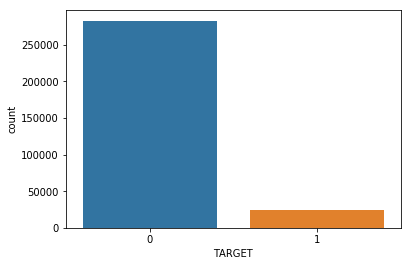

In [11]:
sns.countplot(x = 'TARGET',data = df_train)
perc_target = (100 * df_train['TARGET'].sum() / df_train['TARGET'].count()).round(4)
print('percentage of default : %0.2f%%' %  perc_target)

**train表的用户逾期率为8.07%。**

### 1-5 查看每列的基本情况

In [12]:
#区分开文本列和数字列
feat_obj = df_all.dtypes[df_all.dtypes == 'object'].index
feat_num = df_all.dtypes[df_all.dtypes != 'object'].index

#### 1-5-1 对文本列进行分析

In [13]:
#看看文本列有多少不同的值（可用train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)）
df_all[feat_obj].apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
dtype: int64

**发现性别列出现3种值，单独查看值的分布。**

In [14]:
df_all['CODE_GENDER'].value_counts()

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

发现性别项内有异常值'XNA',用‘NaN’代替

In [15]:
df_all['CODE_GENDER'].replace('XNA', np.nan, inplace = True )

**对文本列做dummy，计算文本列特征与target的相关度。**

In [16]:
feat_obj_dum = pd.get_dummies(df_all[feat_obj], dummy_na = True)
df_all = pd.concat([df_all, feat_obj_dum], axis = 1)
#删除原文本列
df_all.drop(feat_obj,axis = 1, inplace = True)

In [17]:
feat_obj_dum['TARGET'] = df_train['TARGET']

**计算文本列与target的相关系数，选取target列进行排序。**

In [18]:
obj_corr = feat_obj_dum.corr()
obj_corr = obj_corr['TARGET']

In [19]:
abs(obj_corr).sort_values(ascending = False).head(10)

TARGET                                               1.000000
NAME_INCOME_TYPE_Working                             0.057481
NAME_EDUCATION_TYPE_Higher education                 0.056593
CODE_GENDER_M                                        0.054713
CODE_GENDER_F                                        0.054704
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
NAME_INCOME_TYPE_Pensioner                           0.046209
ORGANIZATION_TYPE_XNA                                0.045987
OCCUPATION_TYPE_Laborers                             0.043019
EMERGENCYSTATE_MODE_No                               0.042201
Name: TARGET, dtype: float64

**以上是前10项相关度较高的文本列，可以看到工作类型，性别和教育类型的相关度比较靠前。**

In [20]:
del feat_obj_dum
gc.collect()

1938

#### 1-5-2 对数字列进行分析

In [21]:
df_all.loc[ : , ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
count,356255.000000,356255.000000,356255.000000,356255.000000
mean,-16041.248841,64317.231413,-4983.593527,-3002.071163
std,4358.803980,141705.532576,3526.968986,1517.901735
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000
25%,-19676.000000,-2781.000000,-7477.000000,-4318.000000
50%,-15755.000000,-1224.000000,-4502.000000,-3252.000000
75%,-12425.000000,-290.000000,-1995.000000,-1717.000000
max,-7338.000000,365243.000000,0.000000,0.000000


**发现DAYS_EMPLOYED的最大值365243天，约等于1000年，可能是异常值，下面对该列进行分析。**

Text(0.5, 0, 'DAYS_EMPLOYED')

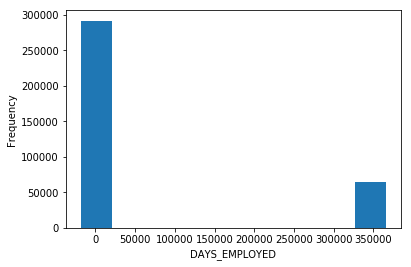

In [22]:
df_all['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('DAYS_EMPLOYED')

**超过50000个用户的DAYS_EMPLOYED在365243上，进一步分析是否需要剔除。
（计算异常值个数、异常值的逾期率和正常值的逾期率）**

In [23]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
nom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
prec_anom = 100 * anom['TARGET'].mean()
prec_nom = 100 * nom['TARGET'].mean()

print('number of anomalies :', len(anom))
print('percent of anomalies that default the loans : %0.2f%%' % prec_anom)
print('percent of nomalies that default the loans :  %0.2f%%' % prec_nom)

number of anomalies : 55374
percent of anomalies that default the loans : 5.40%
percent of nomalies that default the loans :  8.66%


In [24]:
del anom, nom
gc.collect()

0

**发现异常值的逾期率低于正常值的逾期率，可以猜测365243并不是表示1000年，而是一个标记特征，所以新增一列DAYS_EMPLOYED_anom，用1表示。**

In [25]:
df_all['DAYS_EMPLOYED_anom'] = df_all['DAYS_EMPLOYED'] == 365243
df_all['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)

In [26]:
anom_dum = pd.get_dummies(df_all['DAYS_EMPLOYED_anom'], dummy_na = True)
df_all = pd.concat([df_all, anom_dum], axis = 1)
df_all.drop(['DAYS_EMPLOYED_anom'],axis = 1, inplace = True)

In [27]:
del anom_dum
gc.collect()

40

**新增DAY_EMPLOYED_PERC，INCOME_CREDIT_PERC，INCOME_PER_PERSON，ANNUITY_INCOME_PERC，PAYMENT_RATE 5列。**

In [28]:
#工作时间占年龄的比率
df_all['DAY_EMPLOYED_PERC'] = df_all['DAYS_EMPLOYED'] / df_all['DAYS_BIRTH']
#总收入占贷款的比率
df_all['INCOME_CREDIT_PERC'] = df_all['AMT_INCOME_TOTAL'] / df_all['AMT_CREDIT']
#该用户家庭的人均收入
df_all['INCOME_PER_PERSON'] = df_all['AMT_INCOME_TOTAL'] / df_all['CNT_FAM_MEMBERS']
#贷款年金占总收入的比率
df_all['ANNUITY_INCOME_PERC'] = df_all['AMT_ANNUITY'] / df_all['AMT_INCOME_TOTAL']
#贷款年金占贷款的比率
df_all['PAYMENT_RATE'] = df_all['AMT_ANNUITY'] / df_all['AMT_CREDIT']

#### 1-5-3 处理outliers

**用温和异常值的公式进行计算。为了少删outliers,把第一分位数Q1和第三分位数Q3的范围由原来的25%和75%变成2%和98%。**

In [29]:
#用train表数据，outliers表示需要删除的行索引
outlier_indices = []
for i in feat_num:
    Q1 = df_train[i].quantile(0.02)
    Q3 = df_train[i].quantile(0.98)
    IQR = Q3 - Q1
    outliers = df_train[(df_train[i] < Q1 - 1.5 * IQR) | (df_train[i] > Q3 + 1.5 * IQR)].index
    outlier_indices.extend(outliers)

In [30]:
#可能存在重复的行索引，先去重
from collections import Counter
outlier_indices = Counter(outlier_indices)#字典形式出现
multiple_outliers = []
for key, values in outlier_indices.items():#字典.items() 函数以列表返回可遍历的(键, 值) 元组数组
    if values > 2:
        multiple_outliers.append(key)  

In [31]:
#需删掉的行数
len(multiple_outliers)
df_all.drop(multiple_outliers, inplace = True)

In [32]:
#train数据集去除outliers后的行列数
df_all.shape

(353683, 268)

#### 1-5-4 计算数字列特征的相关系数

In [33]:
tem = df_train[feat_num]
tem["TARGET"] = df_train["TARGET"]
num_corr = tem.corr()

In [34]:
abs(num_corr['TARGET']).sort_values(ascending = False)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE     0.037227
ELEVATORS_AVG                  0.034199
ELEVATORS_MEDI                 0.033863
FLOORSMIN_AVG                  0.033614
FLOORSMIN_MEDI                 0.033394


**发现'EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1'相关系数比较高，选取出现频率较高的值生成对应的dummy列。
余下的数字列中把非重复值大于150个的特征看做连续型，小于等于150的看做离散型并生成对应的dummy列。**

In [35]:
num_value_count = df_all[feat_num].apply(pd.Series.nunique, axis = 0)

In [36]:
feat_num_dum = num_value_count[num_value_count <= 150].index.tolist()
feat_num_not_dum = num_value_count[num_value_count > 150].index.tolist()
print('There are %d feature of num need to get dummy.' % len(feat_num_dum))
print('There are %d feature of num left.' % len(feat_num_not_dum))

There are 59 feature of num need to get dummy.
There are 46 feature of num left.


In [37]:
df_all = pd.get_dummies(df_all, columns = feat_num_dum, dummy_na = True )

In [38]:
df_all.shape

(353683, 1262)

**单独取出ext_source的数据分析。由于空值较多，影响下面画图效果，需去掉空值行。**

In [39]:
df_train['EXT_SOURCE_1'].value_counts().sort_values(ascending = False)

0.499002    5
0.528197    5
0.546426    5
0.667740    5
0.605152    5
0.581015    5
0.598469    5
0.356323    5
0.443982    5
0.765724    5
0.622707    5
0.559745    4
0.597077    4
0.654808    4
0.432788    4
0.383865    4
0.346065    4
0.510226    4
0.814155    4
0.491107    4
0.410370    4
0.467634    4
0.433849    4
0.817102    4
0.602788    4
0.695548    4
0.655730    4
0.296741    4
0.762222    4
0.732923    4
           ..
0.557175    1
0.796305    1
0.435287    1
0.443801    1
0.556139    1
0.661529    1
0.388638    1
0.370336    1
0.516140    1
0.569150    1
0.909442    1
0.184929    1
0.200502    1
0.445482    1
0.154653    1
0.332460    1
0.681184    1
0.132241    1
0.543706    1
0.412901    1
0.064265    1
0.811370    1
0.745310    1
0.432115    1
0.520393    1
0.177621    1
0.815926    1
0.623406    1
0.456863    1
0.633382    1
Name: EXT_SOURCE_1, Length: 114584, dtype: int64

In [40]:
ext_source = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df_ext_source = df_all[ext_source]
for i in ext_source:
    print(df_ext_source[i].isnull().sum())
    
df_ext_source.dropna(inplace = True)
print(df_ext_source.head(20))

192529
661
69128
    EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
0       0.083037      0.262949      0.139376
6       0.774761      0.724000      0.492060
8       0.587334      0.205747      0.751724
10      0.319760      0.651862      0.363945
11      0.722044      0.555183      0.652897
12      0.464831      0.715042      0.176653
15      0.115634      0.346634      0.678568
21      0.437709      0.233767      0.542445
25      0.561948      0.651406      0.461482
28      0.600396      0.685011      0.524496
36      0.842763      0.681699      0.754406
37      0.804586      0.719799      0.722393
42      0.468208      0.674203      0.399676
48      0.710427      0.589187      0.466864
50      0.656225      0.450850      0.479449
51      0.311510      0.713355      0.309275
52      0.244562      0.705947      0.799297
53      0.189596      0.702979      0.701696
55      0.552772      0.616637      0.070109
57      0.237720      0.609135      0.513694


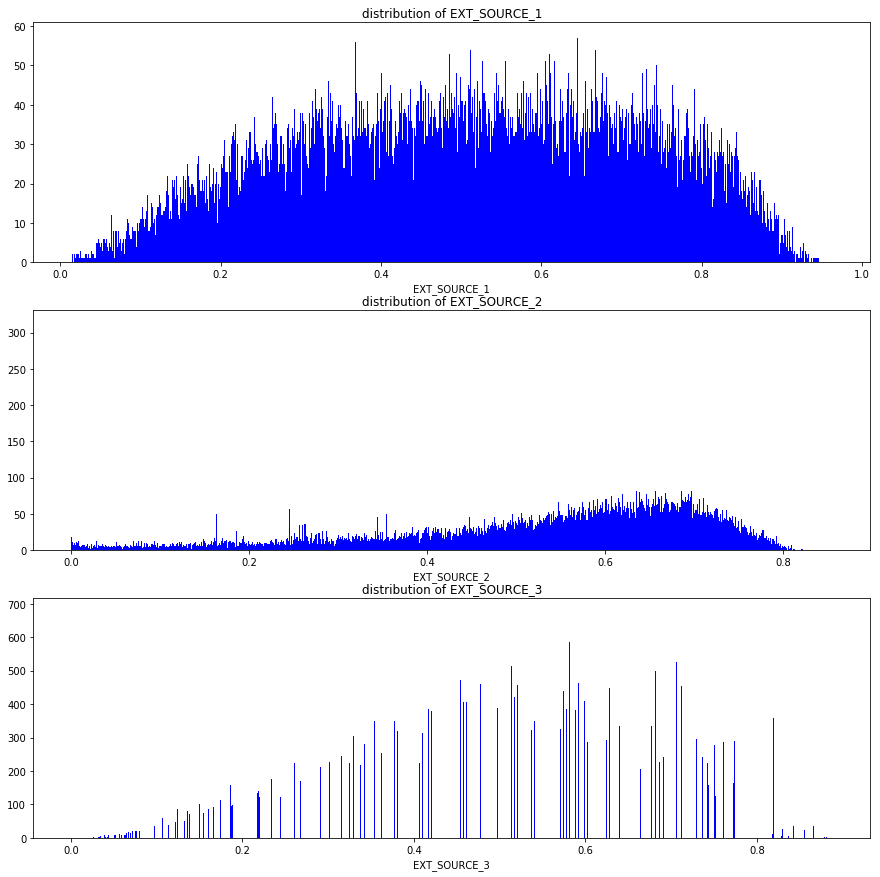

In [41]:
plt.figure(figsize = (15, 15))
for i, col in enumerate(ext_source):
    plt.subplot(3, 1, i + 1)
    plt.hist(df_ext_source[col], bins = 5000, color = 'blue')
    plt.title('distribution of %s' % col)
    plt.xlabel('%s' % col)   

**从上图可以看出，3个特征的非空值分布在0—1之间。**

**EXT_SOURCE_1
由于每个值的出现频率都比较小，不做dummy。**

In [42]:
#新增一列EXT_SOURCE_1_null，表示EXT_SOURCE_1是否为空值，空值记为1
df_all['EXT_SOURCE_1_null'] = 0
df_all['EXT_SOURCE_1_null'][df_all['EXT_SOURCE_1'].isnull()] = 1

In [43]:
#验证是否有遗漏
df_all['EXT_SOURCE_1_null'].sum()

192529

**EXT_SOURCE_2**

In [44]:
#新增一列，表示是否为空值。空值记为1
df_all['EXT_SOURCE_2_null'] = 0
df_all['EXT_SOURCE_2_null'][df_all['EXT_SOURCE_2'].isnull()] = 1

In [45]:
#验证是否有遗漏
df_all['EXT_SOURCE_2_null'].sum()

661

In [46]:
#查看计数量较多的值
tem = df_all['EXT_SOURCE_2'].value_counts().sort_values(ascending = False)

In [47]:
#计数量大于100的值有21个
tem[tem > 100].shape[0]

21

In [48]:
#计数量大于100的值生成dummy列
for i in tem[tem > 100].index:
    df_all['EXT_SOURCE_2' + str(i)] = 0
    df_all['EXT_SOURCE_2' + str(i)][df_all['EXT_SOURCE_2'] == i] = 1

In [49]:
df_all.shape

(353683, 1285)

**EXT_SOURCE_3**

In [50]:
#新增一列，表示是否为空值。空值记为1
df_all['EXT_SOURCE_3_null'] = 0
df_all['EXT_SOURCE_3_null'][df_all['EXT_SOURCE_3'].isnull()] = 1

In [51]:
#验证是否有遗漏
df_all['EXT_SOURCE_3_null'].sum()

69128

In [52]:
#查看计数量较多的值
tem = df_all['EXT_SOURCE_3'].value_counts().sort_values(ascending = False)

In [53]:
#计数量大于1000的值有48个
tem[tem > 1000].shape[0]

48

In [54]:
#计数量大于1000的值生成dummy列
for i in tem[tem > 1000].index:
    df_all['EXT_SOURCE_3' + str(i)] = 0
    df_all['EXT_SOURCE_3' + str(i)][df_all['EXT_SOURCE_3'] == i] = 1

In [55]:
df_all.shape

(353683, 1334)

In [56]:
df_all.fillna(-1, inplace = True)

In [57]:
#检验是有全部填好空值
df_all.isnull().sum()

AMT_ANNUITY                       0
AMT_CREDIT                        0
AMT_GOODS_PRICE                   0
AMT_INCOME_TOTAL                  0
APARTMENTS_AVG                    0
APARTMENTS_MEDI                   0
APARTMENTS_MODE                   0
BASEMENTAREA_AVG                  0
BASEMENTAREA_MEDI                 0
BASEMENTAREA_MODE                 0
COMMONAREA_AVG                    0
COMMONAREA_MEDI                   0
COMMONAREA_MODE                   0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_ID_PUBLISH                   0
DAYS_LAST_PHONE_CHANGE            0
DAYS_REGISTRATION                 0
ELEVATORS_AVG                     0
ENTRANCES_AVG                     0
EXT_SOURCE_1                      0
EXT_SOURCE_2                      0
EXT_SOURCE_3                      0
FLOORSMAX_AVG                     0
FLOORSMIN_AVG                     0
LANDAREA_AVG                      0
LANDAREA_MEDI                     0
LANDAREA_MODE               

## 二、探索数据（剩余6张表）

#### 2-1 用bureau和bureau_balance表做特征

In [58]:
bureau = pd.read_csv('../input/bureau.csv')
bb = pd.read_csv('../input/bureau_balance.csv')

**通过提前做好one hot后，group by统计离散变量的出现次数占比，出现总次数。
并且统计每个SK_ID_BUREAU的MONTHS_BALANCE的最大值，最小值，计数。**

**同时这种先one hot，再groupby统计特征的min，max，mean等数值的方法贯穿下列各张表。后续各张表的处理过程中不再赘述。**

In [59]:
#定义对dataframe做one hot的函数。其中只对‘object’类型的列做转化。
def one_hot_encoder(df, nan_category = True):
    original_cols = list(df.columns)
    categorial_cols = [col for col in df.columns if df[col].dtypes == 'object']
    df = pd.get_dummies(df, columns = categorial_cols, dummy_na = nan_category)
    new_columns = [i for i in df.columns if i not in original_cols]
    return df, new_columns

In [60]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [61]:
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [62]:
b_obj = bureau.dtypes[bureau.dtypes == 'object'].index
bb_obj = bb.dtypes[bb.dtypes == 'object'].index

In [63]:
bureau[b_obj].apply(pd.Series.nunique, axis = 0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [64]:
bb[bb_obj].apply(pd.Series.nunique, axis = 0)

STATUS    8
dtype: int64

In [65]:
bureau, bureau_cat = one_hot_encoder(bureau)
bb, bb_cat = one_hot_encoder(bb)

In [66]:
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size'] } #统计最小值，最大值，出现笔数
for i in bb_cat:
    bb_aggregations[i] = ['mean','sum'] #算出占比和总次数

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
tem = []
for i in bb_agg.columns.tolist():
    tem.append(i[0] + '_' + i[1])
bb_agg.columns = pd.Index(tem)

In [67]:
bb_agg.head()

,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_size,STATUS_0_mean,STATUS_0_sum,STATUS_1_mean,STATUS_1_sum,STATUS_2_mean,STATUS_2_sum,STATUS_3_mean,STATUS_3_sum,STATUS_4_mean,STATUS_4_sum,STATUS_5_mean,STATUS_5_sum,STATUS_C_mean,STATUS_C_sum,STATUS_X_mean,STATUS_X_sum,STATUS_nan_mean,STATUS_nan_sum
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5001709,-96,0,97,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.886598,86,0.113402,11,0,0
5001710,-82,0,83,0.060241,5,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.578313,48,0.361446,30,0,0
5001711,-3,0,4,0.750000,3,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.250000,1,0,0
5001712,-18,0,19,0.526316,10,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.473684,9,0.000000,0,0,0
5001713,-21,0,22,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,1.000000,22,0,0


In [68]:
#按SK_ID_BUREAU连接bureau和bb表
bureau = bureau.join(bb_agg, how= 'left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis= 1, inplace= True)

In [69]:
del bb_agg, bb
gc.collect()

208

In [70]:
bureau.head()

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_CURRENCY_nan,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_nan,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_size,STATUS_0_mean,STATUS_0_sum,STATUS_1_mean,STATUS_1_sum,STATUS_2_mean,STATUS_2_sum,STATUS_3_mean,STATUS_3_sum,STATUS_4_mean,STATUS_4_sum,STATUS_5_mean,STATUS_5_sum,STATUS_C_mean,STATUS_C_sum,STATUS_X_mean,STATUS_X_sum,STATUS_nan_mean,STATUS_nan_sum
0,215354,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
#最后统计每个SK_ID_CURR的历史SK_ID_BUREAU信息。对所有数值计算最小值，最大值，均值，方差，总和
tem = bureau.columns.tolist()
num_agg = { }
for i in tem:
    if i != 'SK_ID_CURR':
        num_agg[i] = ['min','max','mean','var','sum']
bureau_agg = bureau.groupby('SK_ID_CURR', as_index = False).agg(num_agg)

tem = [ ]
tem.append('SK_ID_CURR')
for i in bureau_agg.columns.tolist():
    if i[0] != 'SK_ID_CURR':
        tem.append('bureau' + '_' + i[0] + '_' + i[1])
bureau_agg.columns = pd.Index(tem)

In [72]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_var,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_var,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_var,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_var,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_var,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_var,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_var,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_var,...,bureau_STATUS_5_mean_min,bureau_STATUS_5_mean_max,bureau_STATUS_5_mean_mean,bureau_STATUS_5_mean_var,bureau_STATUS_5_mean_sum,bureau_STATUS_5_sum_min,bureau_STATUS_5_sum_max,bureau_STATUS_5_sum_mean,bureau_STATUS_5_sum_var,bureau_STATUS_5_sum_sum,bureau_STATUS_C_mean_min,bureau_STATUS_C_mean_max,bureau_STATUS_C_mean_mean,bureau_STATUS_C_mean_var,bureau_STATUS_C_mean_sum,bureau_STATUS_C_sum_min,bureau_STATUS_C_sum_max,bureau_STATUS_C_sum_mean,bureau_STATUS_C_sum_var,bureau_STATUS_C_sum_sum,bureau_STATUS_X_mean_min,bureau_STATUS_X_mean_max,bureau_STATUS_X_mean_mean,bureau_STATUS_X_mean_var,bureau_STATUS_X_mean_sum,bureau_STATUS_X_sum_min,bureau_STATUS_X_sum_max,bureau_STATUS_X_sum_mean,bureau_STATUS_X_sum_var,bureau_STATUS_X_sum_sum,bureau_STATUS_nan_mean_min,bureau_STATUS_nan_mean_max,bureau_STATUS_nan_mean_mean,bureau_STATUS_nan_mean_var,bureau_STATUS_nan_mean_sum,bureau_STATUS_nan_sum_min,bureau_STATUS_nan_sum_max,bureau_STATUS_nan_sum_mean,bureau_STATUS_nan_sum_var,bureau_STATUS_nan_sum_sum
0,100001,-1572,-49,-735.000000,240043.666667,-5145,0,0,0.0,0.0,0,-1329.0,1778.0,82.428571,1.066798e+06,577.0,-1328.0,-544.0,-825.500000,136219.000000,-3302.0,NaN,NaN,NaN,NaN,0.000,0,0,0.0,0.0,0,85500.0,378000.0,207623.571429,1.501717e+10,1453365.000,0.0,373239.0,85240.928571,1.890230e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.966667,0.441240,0.183679,3.088683,0.0,44.0,15.714286,288.904762,110.0,0.0,0.500000,0.214590,0.033347,1.502129,0.0,9.0,4.285714,14.571429,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,-1437,-103,-874.000000,186150.000000,-6992,0,0,0.0,0.0,0,-1072.0,780.0,-349.000000,5.890424e+05,-2094.0,-1185.0,-36.0,-697.500000,266248.300000,-4185.0,0.0,5043.645,1681.029,5.584936e+06,8405.145,0,0,0.0,0.0,0,0.0,450000.0,108131.945625,2.133807e+10,865055.565,0.0,245781.0,49156.200000,1.208166e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812500,0.175426,0.069247,1.403409,0.0,13.0,2.875000,17.553571,23.0,0.0,0.500000,0.161932,0.026131,1.295455,0.0,3.0,1.875000,1.839286,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,-2586,-606,-1400.750000,827783.583333,-5603,0,0,0.0,0.0,0,-2434.0,1216.0,-544.500000,2.228364e+06,-2178.0,-2131.0,-540.0,-1097.333333,802990.333333,-3292.0,0.0,0.000,0.000,0.000000e+00,0.000,0,0,0.0,0.0,0,22248.0,810000.0,254350.125000,1.385846e+11,1017400.500,0.0,0.0,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
3,100004,-1326,-408,-867.000000,421362.000000,-1734,0,0,0.0,0.0,0,-595.0,-382.0,-488.500000,2.268450e+04,-977.0,-683.0,-382.0,-532.500000,45300.500000,-1065.0,0.0,0.000,0.000,NaN,0.000,0,0,0.0,0.0,0,94500.0,94537.8,94518.900000,7.144200e+02,189037.800,0.0,0.0,0.000000,0.000000e+00,...,NaN,NaN,NaN

In [73]:
#拼接到df_all表上，记为df_allX
df_allX = df_all.merge(bureau_agg, how = 'left', on= 'SK_ID_CURR')

In [74]:
df_allX.shape

(353683, 1629)

In [75]:
del bureau, bureau_agg
gc.collect()

70

#### 2-2 用installments_payments表做特征

In [76]:
ip = pd.read_csv('../input/installments_payments.csv')

##### 2-2-1 计算每一笔逾期天数，找出出现逾期的用户及逾期次数

In [77]:
ip.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [78]:
#新增一列DEFAULT_DAY，表示每笔的逾期天数
ip['DEFAULT_DAY'] = ip['DAYS_ENTRY_PAYMENT'] - ip['DAYS_INSTALMENT']
tem = ip[ip['DEFAULT_DAY'] > 0]#逾期天数大于0
tem = tem.loc[: ,['SK_ID_CURR','DEFAULT_DAY']]
#计算每个SK_ID_CURR的逾期总天数和逾期总次数
default_days_agg = tem.groupby('SK_ID_CURR', as_index = False).agg({ 'DEFAULT_DAY' : [ 'sum', 'count']})

print(default_days_agg.head())

  SK_ID_CURR DEFAULT_DAY      
                     sum count
0     100001        11.0     1
1     100005         1.0     1
2     100007        63.0    16
3     100008      1317.0     1
4     100009         7.0     1


In [79]:
tem = []
tem.append('SK_ID_CURR')
for i in default_days_agg.columns.tolist():
    if i[0] != 'SK_ID_CURR':
        tem.append('ip' + '_' + i[0] + '_' + i[1])
default_days_agg.columns = pd.Index(tem)

print(default_days_agg.head())

   SK_ID_CURR  ip_DEFAULT_DAY_sum  ip_DEFAULT_DAY_count
0      100001                11.0                     1
1      100005                 1.0                     1
2      100007                63.0                    16
3      100008              1317.0                     1
4      100009                 7.0                     1


In [80]:
df_allX = df_allX.merge(default_days_agg, how = 'left', on = 'SK_ID_CURR')

In [81]:
del default_days_agg
gc.collect()

35

##### 2-2-2 计算每个用户历史借款次数和总分期数

In [82]:
ip['MONEY'] = ip['AMT_INSTALMENT'] - ip['AMT_PAYMENT']
tem = ip.loc[: ,['SK_ID_PREV', 'SK_ID_CURR', 'MONEY']]

In [83]:
tem = tem.groupby(['SK_ID_CURR','SK_ID_PREV'], as_index = False).count().rename(columns={'MONEY': 'TIMES'})

In [84]:
tem = tem.groupby('SK_ID_CURR', as_index = False).agg({'SK_ID_PREV': 'count', 'TIMES': 'sum'})

In [85]:
tem = tem.rename(index = str, columns = {"SK_ID_PREV": "ip_CREDIT_TIMES", "TIMES": "ip_TOTAL_INSTALLMENT_TIMES"})

In [86]:
tem.head()

,SK_ID_CURR,ip_CREDIT_TIMES,ip_TOTAL_INSTALLMENT_TIMES
0,100001,2,7
1,100002,1,19
2,100003,3,25
3,100004,1,3
4,100005,1,9


In [87]:
df_allX = df_allX.merge(tem,how = 'left', on = 'SK_ID_CURR')

In [88]:
df_allX.shape

(353683, 1633)

##### 2-2-3 计算每笔分期的逾期金额

In [89]:
tem = ip.groupby('SK_ID_CURR', as_index = False).agg({'AMT_INSTALMENT':'sum', 'AMT_PAYMENT':'sum'})
tem['ip_default_money'] = tem['AMT_INSTALMENT'] - tem['AMT_PAYMENT']
tem = tem.loc[:,['SK_ID_CURR','ip_default_money']]

In [90]:
df_allX = df_allX.merge(tem, how = 'left', on= 'SK_ID_CURR')

In [91]:
del ip, tem
gc.collect()

35

#### 2-3 用previous_application表做特征

In [92]:
pa = pd.read_csv('../input/previous_application.csv')

In [93]:
pa.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
pa, pa_cat = one_hot_encoder(pa)

In [95]:
#新加一列特征：申请金额占与实际发放金额的比值
pa['application_credit_perc'] = pa['AMT_APPLICATION']/ pa['AMT_CREDIT']

In [96]:
cat_agg = { }
for i in pa_cat:
    cat_agg[i] = ['mean', 'sum']
    
num_agg = {
    'AMT_ANNUITY': ['min','max','mean'],
    'AMT_APPLICATION':['min','max','mean'],
    'AMT_CREDIT':['min','max','mean'],
    'AMT_DOWN_PAYMENT':['min','max','mean'],
    'AMT_GOODS_PRICE':['min','max','mean'],
    'application_credit_perc':['min','max','mean','var'],
    'HOUR_APPR_PROCESS_START':['min','max','mean'],
    'RATE_DOWN_PAYMENT':['min','max','mean'],
    'DAYS_DECISION':['min','max','mean'],
    'CNT_PAYMENT':['sum','mean']
}

pa_agg = pa.groupby('SK_ID_CURR', as_index = False).agg({**cat_agg, **num_agg})

In [97]:
pa_agg.head()

SK_ID_CURR NAME_CONTRACT_TYPE_Cash loans      ...  DAYS_DECISION CNT_PAYMENT      
                                      mean sum  ...           mean         sum  mean
0     100001                      0.000000   0  ...        -1740.0         8.0   8.0
1     100002                      0.000000   0  ...         -606.0        24.0  24.0
2     100003                      0.333333   1  ...        -1305.0        30.0  10.0
3     100004                      0.000000   0  ...         -815.0         4.0   4.0
4     100005                      0.500000   1  ...         -536.0        12.0  12.0

[5 rows x 349 columns]

In [98]:
tem = []
tem.append('SK_ID_CURR')
for i in pa_agg.columns.tolist():
    if i[0] != 'SK_ID_CURR':
        tem.append(i[0] + '_' + i[1])
pa_agg.columns = pd.Index(tem)

In [99]:
df_allX = df_allX.merge(pa_agg, how = 'left', on = 'SK_ID_CURR')

In [100]:
df_allX.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,ELEVATORS_AVG,ENTRANCES_AVG,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,SK_ID_CURR,...,PRODUCT_COMBINATION_POS mobile with interest_mean,PRODUCT_COMBINATION_POS mobile with interest_sum,PRODUCT_COMBINATION_POS mobile without interest_mean,PRODUCT_COMBINATION_POS mobile without interest_sum,PRODUCT_COMBINATION_POS other with interest_mean,PRODUCT_COMBINATION_POS other with interest_sum,PRODUCT_COMBINATION_POS others without interest_mean,PRODUCT_COMBINATION_POS others without interest_sum,PRODUCT_COMBINATION_nan_mean,PRODUCT_COMBINATION_nan_sum,AMT_ANNUITY_min,AMT_ANNUITY_max,AMT_ANNUITY_mean,AMT_APPLICATION_min,AMT_APPLICATION_max,AMT_APPLICATION_mean,AMT_CREDIT_min,AMT_CREDIT_max,AMT_CREDIT_mean,AMT_DOWN_PAYMENT_min,AMT_DOWN_PAYMENT_max,AMT_DOWN_PAYMENT_mean,AMT_GOODS_PRICE_min,AMT_GOODS_PRICE_max,AMT_GOODS_PRICE_mean,application_credit_perc_min,application_credit_perc_max,application_credit_perc_mean,application_credit_perc_var,HOUR_APPR_PROCESS_START_min,HOUR_APPR_PROCESS_START_max,HOUR_APPR_PROCESS_START_mean,RATE_DOWN_PAYMENT_min,RATE_DOWN_PAYMENT_max,RATE_DOWN_PAYMENT_mean,DAYS_DECISION_min,DAYS_DECISION_max,DAYS_DECISION_mean,CNT_PAYMENT_sum,CNT_PAYMENT_mean
0,24700.5,406597.5,351000.0,202500.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0.0143,0.0144,0.0144,-9461,-637.0,-2120,-1134.0,-3648.0,0.00,0.0690,0.083037,0.262949,0.139376,0.0833,0.1250,0.0369,0.0375,0.0377,0.0202,0.0205,0.022,0.0190,0.0193,0.0198,0.0000,0.0000,0.0000,0.00,0.0,100002,...,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,0.00,0.0,0.00,179055.00,179055.0,179055.00,1.000000,1.000000,1.000000,NaN,9.0,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.0,24.000000
1,35698.5,1293502.5,1129500.0,270000.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0.0605,0.0608,0.0497,-16765,-1188.0,-291,-828.0,-1186.0,0.08,0.0345,0.311267,0.622246,-1.000000,0.2917,0.3333,0.0130,0.0132,0.0128,0.0773,0.0787,0.079,0.0549,0.0558,0.0554,0.0039,0.0039,0.0098,0.01,0.0,100003,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.00,6885.0,3442.50,68809.50,900000.0,435436.50,0.868825,1.011109,0.949329,0.005324,12.0,17.0,14.666667,0.000000,0.100061,0.050030,-2341.0,-746.0,-1305.000000,30.0,10.000000
2,6750.0,135000.0,135000.0,67500.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19046,-225.0,-2531,-815.0,-4260.0,-1.00,-1.0000,-1.000000,0.555912,0.729567,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.00,-1.0,100004,...,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,4860.00,4860.0,4860.00,24282.00,24282.0,24282.00,1.207699,1.207699,1.207699,NaN,5.0,5.0,5.000000,0.212008,0.212008,0.212008,-815.0,-815.0,-815.000000,4.0,4.000000
3,29686.5,312682.5,297000.0,135000.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19005,-3039.0,-2437,-617.0,-9833.0,-1.00,-1.0000,-1.000000,0.650442,-1.000000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.00,-1.0,100006,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2482.920,39954.510,23651.175,0.0,688500.0,272203.26,0.0,906615.0,291695.50,2693.34,66987.0,34840.17,26912.

In [101]:
del pa_agg, pa
gc.collect()

140

#### 2-4 用POS_CASH_balance表做特征

In [102]:
pcb = pd.read_csv('../input/POS_CASH_balance.csv')

**增加STATUS_COMPLETED一列，1表示Contract status = 'Completed'，0为其他状态**

In [103]:
pcb['STATUS_COMPLETED'] = 0
for i in range(pcb['NAME_CONTRACT_STATUS'].shape[0]):
    if pcb['NAME_CONTRACT_STATUS'].values[i] == 'Completed':
        pcb['STATUS_COMPLETED'].values[i] = 1

In [104]:
pcb, pcb_cat = one_hot_encoder(pcb)

In [105]:
pcb_cat_agg = { }
for i in pcb_cat:
    pcb_cat_agg[i] = ['mean','sum']

pcb_num_agg = { 
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean'],
    'STATUS_COMPLETED':['sum']
}

In [106]:
pcb_agg = pcb.groupby('SK_ID_CURR', as_index = False).agg({**pcb_cat_agg, **pcb_num_agg})

In [107]:
tem = [ ]
tem.append('SK_ID_CURR')
for i in pcb_agg.columns.tolist():
    if i[0] != 'SK_ID_CURR':
        tem.append('pcb' + '_' + i[0] + '_' + i[1])
pcb_agg.columns = pd.Index(tem)

In [108]:
#新增一列:每个用户的记录数
pcb_agg['pcb_count'] = pcb.groupby('SK_ID_CURR').size()

In [109]:
pcb_agg.head()

,SK_ID_CURR,pcb_NAME_CONTRACT_STATUS_Active_mean,pcb_NAME_CONTRACT_STATUS_Active_sum,pcb_NAME_CONTRACT_STATUS_Amortized debt_mean,pcb_NAME_CONTRACT_STATUS_Amortized debt_sum,pcb_NAME_CONTRACT_STATUS_Approved_mean,pcb_NAME_CONTRACT_STATUS_Approved_sum,pcb_NAME_CONTRACT_STATUS_Canceled_mean,pcb_NAME_CONTRACT_STATUS_Canceled_sum,pcb_NAME_CONTRACT_STATUS_Completed_mean,pcb_NAME_CONTRACT_STATUS_Completed_sum,pcb_NAME_CONTRACT_STATUS_Demand_mean,pcb_NAME_CONTRACT_STATUS_Demand_sum,pcb_NAME_CONTRACT_STATUS_Returned to the store_mean,pcb_NAME_CONTRACT_STATUS_Returned to the store_sum,pcb_NAME_CONTRACT_STATUS_Signed_mean,pcb_NAME_CONTRACT_STATUS_Signed_sum,pcb_NAME_CONTRACT_STATUS_XNA_mean,pcb_NAME_CONTRACT_STATUS_XNA_sum,pcb_NAME_CONTRACT_STATUS_nan_mean,pcb_NAME_CONTRACT_STATUS_nan_sum,pcb_MONTHS_BALANCE_max,pcb_MONTHS_BALANCE_mean,pcb_MONTHS_BALANCE_size,pcb_SK_DPD_max,pcb_SK_DPD_mean,pcb_SK_DPD_DEF_max,pcb_SK_DPD_DEF_mean,pcb_STATUS_COMPLETED_sum,pcb_count
0,100001,0.777778,7.0,0.0,0,0.0,0,0.0,0,0.222222,2,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-53,-72.555556,9,7,0.777778,7,0.777778,2,NaN
1,100002,1.000000,19.0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-1,-10.000000,19,0,0.000000,0,0.000000,0,NaN
2,100003,0.928571,26.0,0.0,0,0.0,0,0.0,0,0.071429,2,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-18,-43.785714,28,0,0.000000,0,0.000000,2,NaN
3,100004,0.750000,3.0,0.0,0,0.0,0,0.0,0,0.250000,1,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-24,-25.500000,4,0,0.000000,0,0.000000,1,NaN
4,100005,0.818182,9.0,0.0,0,0.0,0,0.0,0,0.090909,1,0.0,0,0.0,0,0.090909,1,0.0,0,0,0,-15,-20.000000,11,0,0.000000,0,0.000000,1,NaN


**对['STATUS_COMPLETED']做特征：每个SK_ID_CURR的历史借款笔数['pcb_PREV_CREDIT_COUNT']、'Completed'笔数的占比['pcb_COMPLETED_PERC']**

In [110]:
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,STATUS_COMPLETED,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA,NAME_CONTRACT_STATUS_nan
0,1803195,182943,-31,48.0,45.0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1715348,367990,-33,36.0,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1784872,397406,-32,12.0,9.0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1903291,269225,-35,48.0,42.0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2341044,334279,-35,36.0,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [111]:
total_completed = pcb.loc[ : , ['SK_ID_CURR', 'STATUS_COMPLETED']].groupby('SK_ID_CURR', as_index = False).sum()
credt_count = pcb.loc[ : , ['SK_ID_CURR', 'SK_ID_PREV']].groupby(
    'SK_ID_CURR', as_index = False).count().rename(columns = {'SK_ID_PREV' : 'pcb_PREV_CREDIT_COUNT'})
tem = total_completed.merge(credt_count, how = 'left', on = 'SK_ID_CURR')
tem['pcb_COMPLETED_PERC'] = tem['STATUS_COMPLETED'] / tem['pcb_PREV_CREDIT_COUNT']
print(tem.head())

   SK_ID_CURR         ...          pcb_COMPLETED_PERC
0      100001         ...                    0.222222
1      100002         ...                    0.000000
2      100003         ...                    0.071429
3      100004         ...                    0.250000
4      100005         ...                    0.090909

[5 rows x 4 columns]


In [112]:
pcb_agg = pcb_agg.merge(tem, how = 'left', on = 'SK_ID_CURR')

In [113]:
pcb_agg.head()

,SK_ID_CURR,pcb_NAME_CONTRACT_STATUS_Active_mean,pcb_NAME_CONTRACT_STATUS_Active_sum,pcb_NAME_CONTRACT_STATUS_Amortized debt_mean,pcb_NAME_CONTRACT_STATUS_Amortized debt_sum,pcb_NAME_CONTRACT_STATUS_Approved_mean,pcb_NAME_CONTRACT_STATUS_Approved_sum,pcb_NAME_CONTRACT_STATUS_Canceled_mean,pcb_NAME_CONTRACT_STATUS_Canceled_sum,pcb_NAME_CONTRACT_STATUS_Completed_mean,pcb_NAME_CONTRACT_STATUS_Completed_sum,pcb_NAME_CONTRACT_STATUS_Demand_mean,pcb_NAME_CONTRACT_STATUS_Demand_sum,pcb_NAME_CONTRACT_STATUS_Returned to the store_mean,pcb_NAME_CONTRACT_STATUS_Returned to the store_sum,pcb_NAME_CONTRACT_STATUS_Signed_mean,pcb_NAME_CONTRACT_STATUS_Signed_sum,pcb_NAME_CONTRACT_STATUS_XNA_mean,pcb_NAME_CONTRACT_STATUS_XNA_sum,pcb_NAME_CONTRACT_STATUS_nan_mean,pcb_NAME_CONTRACT_STATUS_nan_sum,pcb_MONTHS_BALANCE_max,pcb_MONTHS_BALANCE_mean,pcb_MONTHS_BALANCE_size,pcb_SK_DPD_max,pcb_SK_DPD_mean,pcb_SK_DPD_DEF_max,pcb_SK_DPD_DEF_mean,pcb_STATUS_COMPLETED_sum,pcb_count,STATUS_COMPLETED,pcb_PREV_CREDIT_COUNT,pcb_COMPLETED_PERC
0,100001,0.777778,7.0,0.0,0,0.0,0,0.0,0,0.222222,2,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-53,-72.555556,9,7,0.777778,7,0.777778,2,NaN,2,9,0.222222
1,100002,1.000000,19.0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-1,-10.000000,19,0,0.000000,0,0.000000,0,NaN,0,19,0.000000
2,100003,0.928571,26.0,0.0,0,0.0,0,0.0,0,0.071429,2,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-18,-43.785714,28,0,0.000000,0,0.000000,2,NaN,2,28,0.071429
3,100004,0.750000,3.0,0.0,0,0.0,0,0.0,0,0.250000,1,0.0,0,0.0,0,0.000000,0,0.0,0,0,0,-24,-25.500000,4,0,0.000000,0,0.000000,1,NaN,1,4,0.250000
4,100005,0.818182,9.0,0.0,0,0.0,0,0.0,0,0.090909,1,0.0,0,0.0,0,0.090909,1,0.0,0,0,0,-15,-20.000000,11,0,0.000000,0,0.000000,1,NaN,1,11,0.090909


In [114]:
df_allX = df_allX.merge(pcb_agg, how = 'left', on= 'SK_ID_CURR')

In [115]:
df_allX.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,ELEVATORS_AVG,ENTRANCES_AVG,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,SK_ID_CURR,...,RATE_DOWN_PAYMENT_min,RATE_DOWN_PAYMENT_max,RATE_DOWN_PAYMENT_mean,DAYS_DECISION_min,DAYS_DECISION_max,DAYS_DECISION_mean,CNT_PAYMENT_sum,CNT_PAYMENT_mean,pcb_NAME_CONTRACT_STATUS_Active_mean,pcb_NAME_CONTRACT_STATUS_Active_sum,pcb_NAME_CONTRACT_STATUS_Amortized debt_mean,pcb_NAME_CONTRACT_STATUS_Amortized debt_sum,pcb_NAME_CONTRACT_STATUS_Approved_mean,pcb_NAME_CONTRACT_STATUS_Approved_sum,pcb_NAME_CONTRACT_STATUS_Canceled_mean,pcb_NAME_CONTRACT_STATUS_Canceled_sum,pcb_NAME_CONTRACT_STATUS_Completed_mean,pcb_NAME_CONTRACT_STATUS_Completed_sum,pcb_NAME_CONTRACT_STATUS_Demand_mean,pcb_NAME_CONTRACT_STATUS_Demand_sum,pcb_NAME_CONTRACT_STATUS_Returned to the store_mean,pcb_NAME_CONTRACT_STATUS_Returned to the store_sum,pcb_NAME_CONTRACT_STATUS_Signed_mean,pcb_NAME_CONTRACT_STATUS_Signed_sum,pcb_NAME_CONTRACT_STATUS_XNA_mean,pcb_NAME_CONTRACT_STATUS_XNA_sum,pcb_NAME_CONTRACT_STATUS_nan_mean,pcb_NAME_CONTRACT_STATUS_nan_sum,pcb_MONTHS_BALANCE_max,pcb_MONTHS_BALANCE_mean,pcb_MONTHS_BALANCE_size,pcb_SK_DPD_max,pcb_SK_DPD_mean,pcb_SK_DPD_DEF_max,pcb_SK_DPD_DEF_mean,pcb_STATUS_COMPLETED_sum,pcb_count,STATUS_COMPLETED,pcb_PREV_CREDIT_COUNT,pcb_COMPLETED_PERC
0,24700.5,406597.5,351000.0,202500.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0.0143,0.0144,0.0144,-9461,-637.0,-2120,-1134.0,-3648.0,0.00,0.0690,0.083037,0.262949,0.139376,0.0833,0.1250,0.0369,0.0375,0.0377,0.0202,0.0205,0.022,0.0190,0.0193,0.0198,0.0000,0.0000,0.0000,0.00,0.0,100002,...,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.0,24.000000,1.000000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-1.0,-10.000000,19.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,19.0,0.000000
1,35698.5,1293502.5,1129500.0,270000.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0.0605,0.0608,0.0497,-16765,-1188.0,-291,-828.0,-1186.0,0.08,0.0345,0.311267,0.622246,-1.000000,0.2917,0.3333,0.0130,0.0132,0.0128,0.0773,0.0787,0.079,0.0549,0.0558,0.0554,0.0039,0.0039,0.0098,0.01,0.0,100003,...,0.000000,0.100061,0.050030,-2341.0,-746.0,-1305.000000,30.0,10.000000,0.928571,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,2.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-18.0,-43.785714,28.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,28.0,0.071429
2,6750.0,135000.0,135000.0,67500.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19046,-225.0,-2531,-815.0,-4260.0,-1.00,-1.0000,-1.000000,0.555912,0.729567,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.00,-1.0,100004,...,0.212008,0.212008,0.212008,-815.0,-815.0,-815.000000,4.0,4.000000,0.750000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-24.0,-25.500000,4.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,4.0,0.250000
3,29686.5,312682.5,297000.0,135000.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19005,-3039.0,-2437,-617.0,-9833.0,-1.00,-1.0000,-1.000000,0.650442,-1.000000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.00,-1.0,100006,...,0.108994,0.217830,0.163412,-617.0,-181.0,-272.444444,138.0,23.000000,0.857143,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,2.0,0.0,0.0,0.047619,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,-1.0,-9.619048,21.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,21.0,0.095238
4,21865.5,513000.0,513000.0,1

In [116]:
del pcb, pcb_agg
gc.collect()

126

#### 2-5 用credit_card_balance表做特征

In [117]:
ccb = pd.read_csv('../input/credit_card_balance.csv')

**增加['STATUS_COMPLETED']一列，1表示Contract status = 'Completed'，0为其他状态**

In [118]:
ccb['STATUS_COMPLETED'] = 0
for i in range(ccb['NAME_CONTRACT_STATUS'].shape[0]):
    if ccb['NAME_CONTRACT_STATUS'].values[i] == 'Completed':
        ccb['STATUS_COMPLETED'].values[i] = 1

In [119]:
ccb, ccb_cat = one_hot_encoder(ccb)

In [120]:
ccb_cat_agg = { }
for i in ccb_cat:
    ccb_cat_agg[i] = ['mean','sum']
    
ccb_num_agg = { 
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean'],
    'STATUS_COMPLETED':['sum']
}

ccb_num = ['AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM']
for i in ccb_num:
    ccb_num_agg[i] = ['min', 'max', 'mean', 'sum', 'var']

In [121]:
ccb_agg = ccb.groupby('SK_ID_CURR', as_index = False).agg({**ccb_cat_agg, **ccb_num_agg})

In [122]:
tem = [ ]
tem.append('SK_ID_CURR')
for i in ccb_agg.columns.tolist():
    if i[0] != 'SK_ID_CURR':
        tem.append('ccb' + '_' + i[0] + '_' + i[1])
ccb_agg.columns = pd.Index(tem)

In [123]:
ccb_agg['ccb_count'] = ccb.groupby('SK_ID_CURR').size()

**对['STATUS_COMPLETED']做特征：每个SK_ID_CURR的借款笔数['ccb_PREV_CREDIT_COUNT']、'Completed'笔数的占比['ccb_COMPLETED_PERC']**

In [124]:
total_completed = ccb.loc[ : , ['SK_ID_CURR', 'STATUS_COMPLETED']].groupby('SK_ID_CURR', as_index = False).sum()
credt_count = ccb.loc[ : , ['SK_ID_CURR', 'SK_ID_PREV']].groupby(
    'SK_ID_CURR', as_index = False).count().rename(columns = {'SK_ID_PREV' : 'ccb_PREV_CREDIT_COUNT'})
tem = total_completed.merge(credt_count, how = 'left', on = 'SK_ID_CURR')
tem['ccb_COMPLETED_PERC'] = tem['STATUS_COMPLETED'] / tem['ccb_PREV_CREDIT_COUNT']
print(tem.head())

   SK_ID_CURR         ...          ccb_COMPLETED_PERC
0      100006         ...                    0.000000
1      100011         ...                    0.000000
2      100013         ...                    0.000000
3      100021         ...                    0.588235
4      100023         ...                    0.000000

[5 rows x 4 columns]


In [125]:
ccb_agg = ccb_agg.merge(tem, how = 'left',on = 'SK_ID_CURR')

In [126]:
ccb_agg.head()

,SK_ID_CURR,ccb_NAME_CONTRACT_STATUS_Active_mean,ccb_NAME_CONTRACT_STATUS_Active_sum,ccb_NAME_CONTRACT_STATUS_Approved_mean,ccb_NAME_CONTRACT_STATUS_Approved_sum,ccb_NAME_CONTRACT_STATUS_Completed_mean,ccb_NAME_CONTRACT_STATUS_Completed_sum,ccb_NAME_CONTRACT_STATUS_Demand_mean,ccb_NAME_CONTRACT_STATUS_Demand_sum,ccb_NAME_CONTRACT_STATUS_Refused_mean,ccb_NAME_CONTRACT_STATUS_Refused_sum,ccb_NAME_CONTRACT_STATUS_Sent proposal_mean,ccb_NAME_CONTRACT_STATUS_Sent proposal_sum,ccb_NAME_CONTRACT_STATUS_Signed_mean,ccb_NAME_CONTRACT_STATUS_Signed_sum,ccb_NAME_CONTRACT_STATUS_nan_mean,ccb_NAME_CONTRACT_STATUS_nan_sum,ccb_MONTHS_BALANCE_max,ccb_MONTHS_BALANCE_mean,ccb_MONTHS_BALANCE_size,ccb_SK_DPD_max,ccb_SK_DPD_mean,ccb_SK_DPD_DEF_max,ccb_SK_DPD_DEF_mean,ccb_STATUS_COMPLETED_sum,ccb_AMT_BALANCE_min,ccb_AMT_BALANCE_max,ccb_AMT_BALANCE_mean,ccb_AMT_BALANCE_sum,ccb_AMT_BALANCE_var,ccb_AMT_CREDIT_LIMIT_ACTUAL_min,ccb_AMT_CREDIT_LIMIT_ACTUAL_max,ccb_AMT_CREDIT_LIMIT_ACTUAL_mean,ccb_AMT_CREDIT_LIMIT_ACTUAL_sum,ccb_AMT_CREDIT_LIMIT_ACTUAL_var,ccb_AMT_DRAWINGS_ATM_CURRENT_min,ccb_AMT_DRAWINGS_ATM_CURRENT_max,ccb_AMT_DRAWINGS_ATM_CURRENT_mean,ccb_AMT_DRAWINGS_ATM_CURRENT_sum,ccb_AMT_DRAWINGS_ATM_CURRENT_var,...,ccb_AMT_RECEIVABLE_PRINCIPAL_var,ccb_AMT_RECIVABLE_min,ccb_AMT_RECIVABLE_max,ccb_AMT_RECIVABLE_mean,ccb_AMT_RECIVABLE_sum,ccb_AMT_RECIVABLE_var,ccb_AMT_TOTAL_RECEIVABLE_min,ccb_AMT_TOTAL_RECEIVABLE_max,ccb_AMT_TOTAL_RECEIVABLE_mean,ccb_AMT_TOTAL_RECEIVABLE_sum,ccb_AMT_TOTAL_RECEIVABLE_var,ccb_CNT_DRAWINGS_ATM_CURRENT_min,ccb_CNT_DRAWINGS_ATM_CURRENT_max,ccb_CNT_DRAWINGS_ATM_CURRENT_mean,ccb_CNT_DRAWINGS_ATM_CURRENT_sum,ccb_CNT_DRAWINGS_ATM_CURRENT_var,ccb_CNT_DRAWINGS_CURRENT_min,ccb_CNT_DRAWINGS_CURRENT_max,ccb_CNT_DRAWINGS_CURRENT_mean,ccb_CNT_DRAWINGS_CURRENT_sum,ccb_CNT_DRAWINGS_CURRENT_var,ccb_CNT_DRAWINGS_OTHER_CURRENT_min,ccb_CNT_DRAWINGS_OTHER_CURRENT_max,ccb_CNT_DRAWINGS_OTHER_CURRENT_mean,ccb_CNT_DRAWINGS_OTHER_CURRENT_sum,ccb_CNT_DRAWINGS_OTHER_CURRENT_var,ccb_CNT_DRAWINGS_POS_CURRENT_min,ccb_CNT_DRAWINGS_POS_CURRENT_max,ccb_CNT_DRAWINGS_POS_CURRENT_mean,ccb_CNT_DRAWINGS_POS_CURRENT_sum,ccb_CNT_DRAWINGS_POS_CURRENT_var,ccb_CNT_INSTALMENT_MATURE_CUM_min,ccb_CNT_INSTALMENT_MATURE_CUM_max,ccb_CNT_INSTALMENT_MATURE_CUM_mean,ccb_CNT_INSTALMENT_MATURE_CUM_sum,ccb_CNT_INSTALMENT_MATURE_CUM_var,ccb_count,STATUS_COMPLETED,ccb_PREV_CREDIT_COUNT,ccb_COMPLETED_PERC
0,100006,1.000000,6,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,-1,-3.5,6,0,0.000000,0,0.000000,0,0.0,0.00,0.000000,0.000,0.000000e+00,270000,270000,270000.000000,1620000,0.000000e+00,NaN,NaN,NaN,0.0,NaN,...,0.000000e+00,0.000,0.00,0.000000,0.000,0.000000e+00,0.000,0.00,0.000000,0.000,0.000000e+00,NaN,NaN,NaN,0.0,NaN,0,0,0.000000,0,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.000000,0.0,0.000000,NaN,0,6,0.000000
1,100011,1.000000,74,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,-2,-38.5,74,0,0.000000,0,0.000000,0,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,90000,180000,164189.189189,12150000,1.189060e+09,0.0,180000.0,2432.432432,180000.0,4.378378e+08,...,4.324223e+09,-563.355,189000.00,54433.179122,4028055.255,4.646736e+09,-563.355,189000.00,54433.179122,4028055.255,4.646736e+09,0.0,4.0,0.054054,4.0,0.216216,0,4,0.054054,4,0.216216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,33.0,25.767123,1881.0,105.847793,NaN,0,74,0.000000
2,100013,1.000000,96,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,-1,-48.5,96,1,0.010417,1,0.010417,0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,45000,157500,131718.750000,12645000,2.259252e+09,0.0,157500.0,6350.000000,571500.0,8.249688e+08,...,1.704017e+09,-274.320,161420.22,18101.079844,1737703.665,1.871603e+09,-274.320,161420.22,18101.079844,1737703.665,1.871603e+09,0.0,7.0,0.255556,23.0,1.405868,0,7,0.239583,23,1.320943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,18.719101,1666.0,34.249745,NaN,0,96,0.000000
3,100021,0.411765,7,0.0,0,0.588235,10,0.0,0,0.0,0,0.0,0,0.0,0,0,0,-2,-10.0,17,0,0.000000,0,0.000000,10,0.0,0.00

In [127]:
df_allX = df_allX.merge(ccb_agg,how = 'left', on= 'SK_ID_CURR')

In [128]:
df_allX.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,ELEVATORS_AVG,ENTRANCES_AVG,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,SK_ID_CURR,...,ccb_AMT_RECEIVABLE_PRINCIPAL_var,ccb_AMT_RECIVABLE_min,ccb_AMT_RECIVABLE_max,ccb_AMT_RECIVABLE_mean,ccb_AMT_RECIVABLE_sum,ccb_AMT_RECIVABLE_var,ccb_AMT_TOTAL_RECEIVABLE_min,ccb_AMT_TOTAL_RECEIVABLE_max,ccb_AMT_TOTAL_RECEIVABLE_mean,ccb_AMT_TOTAL_RECEIVABLE_sum,ccb_AMT_TOTAL_RECEIVABLE_var,ccb_CNT_DRAWINGS_ATM_CURRENT_min,ccb_CNT_DRAWINGS_ATM_CURRENT_max,ccb_CNT_DRAWINGS_ATM_CURRENT_mean,ccb_CNT_DRAWINGS_ATM_CURRENT_sum,ccb_CNT_DRAWINGS_ATM_CURRENT_var,ccb_CNT_DRAWINGS_CURRENT_min,ccb_CNT_DRAWINGS_CURRENT_max,ccb_CNT_DRAWINGS_CURRENT_mean,ccb_CNT_DRAWINGS_CURRENT_sum,ccb_CNT_DRAWINGS_CURRENT_var,ccb_CNT_DRAWINGS_OTHER_CURRENT_min,ccb_CNT_DRAWINGS_OTHER_CURRENT_max,ccb_CNT_DRAWINGS_OTHER_CURRENT_mean,ccb_CNT_DRAWINGS_OTHER_CURRENT_sum,ccb_CNT_DRAWINGS_OTHER_CURRENT_var,ccb_CNT_DRAWINGS_POS_CURRENT_min,ccb_CNT_DRAWINGS_POS_CURRENT_max,ccb_CNT_DRAWINGS_POS_CURRENT_mean,ccb_CNT_DRAWINGS_POS_CURRENT_sum,ccb_CNT_DRAWINGS_POS_CURRENT_var,ccb_CNT_INSTALMENT_MATURE_CUM_min,ccb_CNT_INSTALMENT_MATURE_CUM_max,ccb_CNT_INSTALMENT_MATURE_CUM_mean,ccb_CNT_INSTALMENT_MATURE_CUM_sum,ccb_CNT_INSTALMENT_MATURE_CUM_var,ccb_count,STATUS_COMPLETED_y,ccb_PREV_CREDIT_COUNT,ccb_COMPLETED_PERC
0,24700.5,406597.5,351000.0,202500.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0.0143,0.0144,0.0144,-9461,-637.0,-2120,-1134.0,-3648.0,0.00,0.0690,0.083037,0.262949,0.139376,0.0833,0.1250,0.0369,0.0375,0.0377,0.0202,0.0205,0.022,0.0190,0.0193,0.0198,0.0000,0.0000,0.0000,0.00,0.0,100002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0.0605,0.0608,0.0497,-16765,-1188.0,-291,-828.0,-1186.0,0.08,0.0345,0.311267,0.622246,-1.000000,0.2917,0.3333,0.0130,0.0132,0.0128,0.0773,0.0787,0.079,0.0549,0.0558,0.0554,0.0039,0.0039,0.0098,0.01,0.0,100003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19046,-225.0,-2531,-815.0,-4260.0,-1.00,-1.0000,-1.000000,0.555912,0.729567,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.00,-1.0,100004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19005,-3039.0,-2437,-617.0,-9833.0,-1.00,-1.0000,-1.000000,0.650442,-1.000000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.00,-1.0,100006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,0.0
4,21865.5,513000.0,513000.0,121500.0,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-19932,-3038.0,-3458,-1106.0,-4311.0,-1.00,-1.0000,-1.000000,0.322738,-1.000000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.000

In [129]:
del ccb, ccb_agg, total_completed, credt_count ,tem
gc.collect()

161

#### 2-6 填空缺值

In [130]:
df_allX.fillna(0, inplace = True)

In [131]:
#取出去掉outliers行后的target
df_target_fin = df_train.drop(multiple_outliers)[['TARGET']].copy()

In [132]:
print(df_target_fin.shape)

del df_train
gc.collect()

(304939, 1)


9

目前**df_allX**有**353683**行，**df_test**有**48744**行，**df_train**有**304939**行

In [133]:
df_allX.drop('SK_ID_CURR',axis = 1, inplace = True )
df_train_fin = df_allX.loc[ : df_target_fin.shape[0]-1, : ].copy()
df_test_fin = df_allX.loc[df_target_fin.shape[0] : , : ].copy()
print(df_train_fin.shape,df_test_fin.shape)

del df_allX
gc.collect()

(304939, 2126) (48744, 2126)


7

## 三、生成建模需用的表格

**因为内存不够，无法接着跑完模型，生成**df_train_fin **和 **df_target_fin **两张CSV备用，作为第二篇笔记进行建模的数据。**

df_train_fin.to_csv('df_train_fin.csv',encoding = 'utf-8',index = 0)
df_test_fin.to_csv('df_test_fin.csv',encoding = 'utf-8',index = 0)
df_target_fin.to_csv('df_target_fin.csv',encoding = 'utf-8',index = 0)

## 四、训练模型，本地验证模型效果，预测测试数据

**需要用到4张表格：df_test（原来的test表）、df_train_fin、 df_test_fin、 df_target_fin**

X = df_train_fin.values
y = df_target_fin['TARGET'].values

del df_train_fin, df_target_fin
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 5)
del X, y
gc.collect()

model = xgboost.XGBClassifier(n_estimatores = 200, max_depth = 8, subsample = 0.8, colsample_bytree = 0.8, 
                              min_child_weight = 50, random_state=27).fit(X_train, y_train)

**#生成train数据放进模型后的答案**
ans = model.predict_proba(X_test)
roc_auc_score(y_test, ans[ : , 1]) 

**#把test数据放进模型**
ans_test = model.predict_proba(df_test_fin.values)
print(ans_test)
**#生成答案**
df_test_fin['TARGET'] = ans_test[:,1]
df_new = df_test_fin.loc[:,['SK_ID_CURR','TARGET']].reset_index()
df_new['SK_ID_CURR'] = df_test['SK_ID_CURR']#用原本的test表
df_new[['SK_ID_CURR','TARGET']].to_csv('05.csv',encoding = 'utf-8',index = 0)

## 五、最后分数

**Private Score：**0.78042.   **Public Score:**0.78267.